In [1]:
%matplotlib inline

# Tarea 5: Reducción de Dimensiones: Datos de tejido canceroso

Tecnológico de Costa Rica<br/>
Aprendizaje Automático <br/>


Cuaderno base para realizar la sección de la tarea 5, relacionada con la identificación de tejido canceroso.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearnex import patch_sklearn
patch_sklearn()
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import umap
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, accuracy_score
from sklearn.model_selection import train_test_split
from visualization import plot_projection

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


## Cargar datos de tejido canceroso

Los datos quedarán almacenados en X y las etiquetas en y

In [3]:
archivo_csv = 'cancer.csv' 

col_label = 1 ## Columna en el CSV con las etiquetas 'B'enigno o 'M'aligno
col_feats = 2 ## Columna en el CSV a partir de la cual se encuentran las características

horizontal=12  ## Tamaño de las figuras
figsize=(horizontal,horizontal/(16/9))

Cargar los nombres de las características

In [4]:
# Read the feature names from the CSV file
with open(archivo_csv, 'r') as file:
    header = file.readline().strip().split(',')
    original_features = header[col_feats:]
    
    # Remove the empty string at the end if present
    if original_features[-1] == "":
        original_features = original_features[:-1]

['"radius_mean"', '"texture_mean"', '"perimeter_mean"', '"area_mean"', '"smoothness_mean"', '"compactness_mean"', '"concavity_mean"', '"concave points_mean"', '"symmetry_mean"', '"fractal_dimension_mean"', '"radius_se"', '"texture_se"', '"perimeter_se"', '"area_se"', '"smoothness_se"', '"compactness_se"', '"concavity_se"', '"concave points_se"', '"symmetry_se"', '"fractal_dimension_se"', '"radius_worst"', '"texture_worst"', '"perimeter_worst"', '"area_worst"', '"smoothness_worst"', '"compactness_worst"', '"concavity_worst"', '"concave points_worst"', '"symmetry_worst"', '"fractal_dimension_worst"']


Cargar todos los datos en archivo csv

In [5]:
## Es necesario manejar manualmente la conversión del caracter en la 1era columna a número
converters={}
for i in range(32):
    converters[i] = lambda x : float(x)
converters[col_label] =  lambda x : 1.0 if (x==b'M') else 0.0

data = np.genfromtxt(archivo_csv, delimiter=',',skip_header=1,converters=converters)
print("Datos completos en matriz {0} x {1}".format(data.shape[0],data.shape[1]))

Datos completos en matriz 569 x 32


In [6]:
# La columna col_labels tiene las etiquetas
y=data[:,col_label].ravel()
print("Label shape:",y.shape)

# La columna col_grupos tiene los grupos
X=data[:,col_feats:32]
print("Data shape :",X.shape)


Label shape: (569,)
Data shape : (569, 30)


### 1. Debido a que la distribucion de las características es muy variada, el primer paso es, como siempre, normalizar los datos.

In [7]:
# Crear el objeto StandardScaler
scaler = StandardScaler()


# Ajustar y transformar las columnas (X)
X_scaled = scaler.fit_transform(X)

### Métodos de reducción de dimensiones:

##### 2. Aplique PCA para proyectar los datos al subespacio de dos dimensiones con los dos componentes principales de mayor varianza.

In [8]:
# Crear el objeto PCA con 2 componentes
pca = PCA(n_components=2)

# Ajustar y transformar los datos escalados
X_pca = pca.fit_transform(X_scaled)


#### 3. Visualice los datos proyectados, utilizando las etiquetas en la segunda columna para identificar las dos clases.

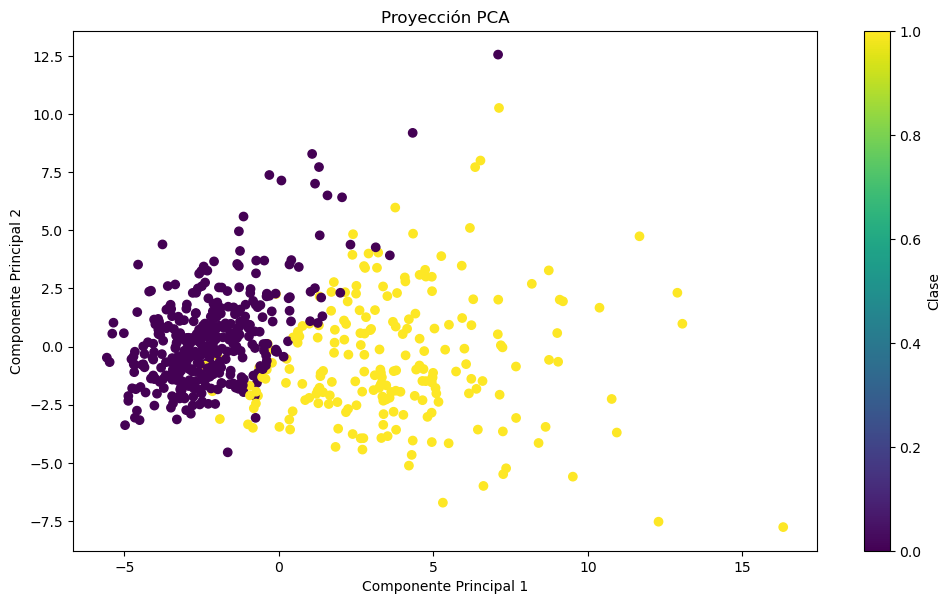

In [9]:
# Visualizar los datos proyectados
plt.figure(figsize=figsize)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('Proyección PCA')
plt.colorbar(label='Clase')
plt.show()

In [10]:
# Imprimir las características con mayor varianza en cada componente principal
# Abrir el archivo y leer solo la primera línea (encabezado)
with open(archivo_csv, 'r') as file:
    header_line = file.readline().strip().split(',')  # Leer la primera línea, eliminar espacios en blanco y dividir por comas

# Convertir la primera línea a una lista de nombres de características
original_features = header_line

# Imprimir las características con mayor varianza en cada componente principal
num_feats_to_show = 5  
print("\nFeatures con mayor varianza en cada Componente Principal:")
for i, component in enumerate(pca.components_):
    sorted_index = np.argsort(np.abs(component))[::-1]
    print(f"Componente Principal {i+1}:")
    for j in range(num_feats_to_show):
        index = sorted_index[j]
        print(f"- {original_features[index]}: {component[index]}")
    print()


Features con mayor varianza en cada Componente Principal:
Componente Principal 1:
- "concave points_mean": 0.2608537583857349
- "concavity_mean": 0.2584004812487785
- "concave points_worst": 0.25088597121798917
- "compactness_mean": 0.23928535395298378
- "perimeter_worst": 0.23663968074164898

Componente Principal 2:
- "fractal_dimension_mean": 0.36657547137985314
- "fractal_dimension_se": 0.280092026610175
- "fractal_dimension_worst": 0.27533946857915553
- "radius_mean": -0.23385713174786157
- "compactness_se": 0.2327158961910286



#### 4. Revise los primeros dos componentes principales (es decir, los dos eigenvectores con los mayores eigenvalores). ¿Es posible identificar si hay ejes en el espacio original más importantes que otros? ¿Es posible visualizar conglomerados en el subespacio bidimensional encontrado con PCA?

**¿Es posible identificar si hay ejes en el espacio original más importantes
que otros?**

Si claro note que la componente 1 es la que tiene tiene mayor varianza. Y si obtenemos los valores de las componentes sus eigenvector, notaremos que hay unos valores más altos que otros. Recuerde que cada componente del eigenvector corresponde a un tipo de "peso" de esa característica en el espacio original. Por lo quiere decir que si tiene  mayor "peso" esa componente del eigenvector quiere decir esa característica aporta mucho en la varianza de los datos. Lo cuál quiere decir que es una característica importante para lograr identificar la clase.


**¿Es posible visualizar conglomerados en el subespacio bidimensional encontrado
con PCA?**

Si note que en el gráfico anterior como se encuentra una conglomerado en la parte izquierda superior de cancer benigno, y un conglomerado en la parte derecha superior de cancer maligno.


#### 5. Repita lo anterior con UMAP, en su versión no supervisada (ver sitio de autores para instrucciones de cómo instalarlo). Experimente con los parámetros de UMAP para lograr una visible separación de las clases.

In [11]:
# Crear el objeto UMAP con parámetros por defecto
umap_unsupervised = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)

# Ajustar y transformar los datos escalados
X_umap_unsupervised = umap_unsupervised.fit_transform(X_scaled)

/home/carlos/y/envs/t5/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


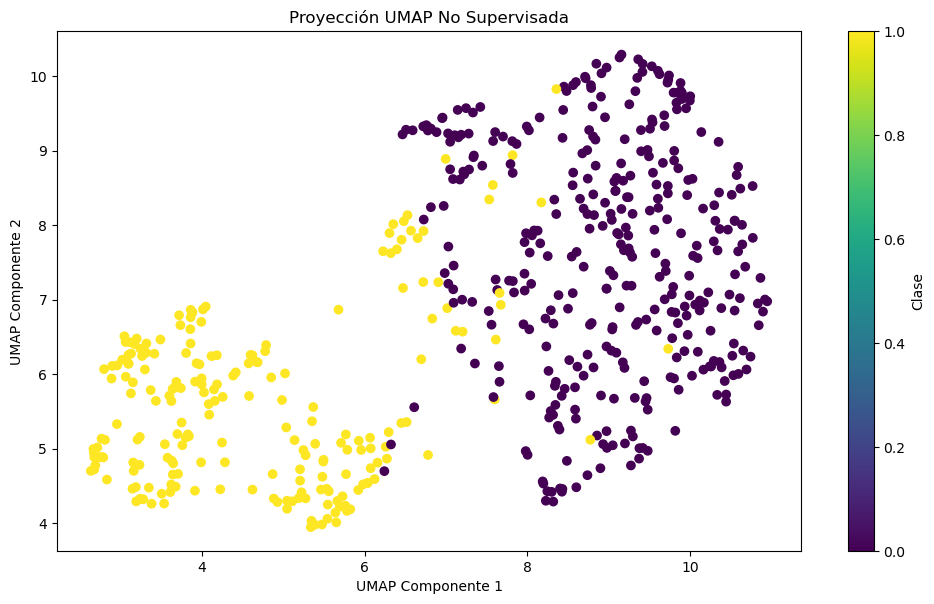

In [12]:
# Visualizar los datos proyectados con UMAP no supervisado
plt.figure(figsize=figsize)
plt.scatter(X_umap_unsupervised[:, 0], X_umap_unsupervised[:, 1], c=y, cmap='viridis')
plt.xlabel('UMAP Componente 1')
plt.ylabel('UMAP Componente 2')
plt.title('Proyección UMAP No Supervisada')
plt.colorbar(label='Clase')
plt.show()

#### 6. Repita lo anterior con la versión supervisada de UMAP, para ayudar al método a encontrar estructuras más afines a un problema de clasificación como tal.

In [13]:
# Crear el objeto UMAP supervisado
umap_supervised = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42, metric='euclidean')

# Ajustar y transformar los datos escalados usando las etiquetas para supervisar
X_umap_supervised = umap_supervised.fit_transform(X_scaled, y)

/home/carlos/y/envs/t5/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


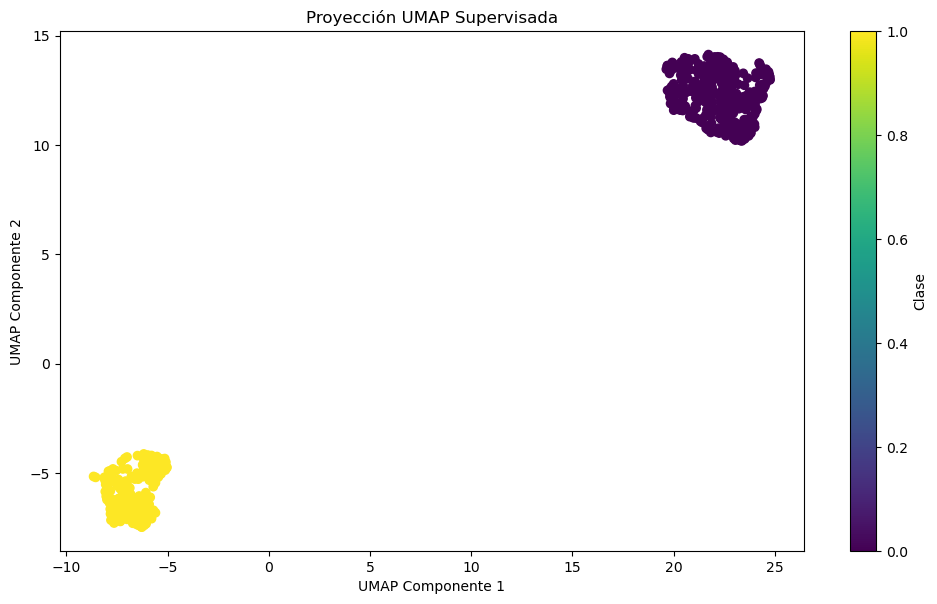

In [14]:
# Visualizar los datos proyectados con UMAP supervisado
plt.figure(figsize=figsize)
plt.scatter(X_umap_supervised[:, 0], X_umap_supervised[:, 1], c=y, cmap='viridis')
plt.xlabel('UMAP Componente 1')
plt.ylabel('UMAP Componente 2')
plt.title('Proyección UMAP Supervisada')
plt.colorbar(label='Clase')
plt.show()


#### 7. De los experimentos anteriores, analice si se pueden observar conglomerados aparentes, y qué número de ellos podría ser interesante evaluar.

**De los experimentos anteriores, analice si se pueden observar conglomerados aparentes, y qué número de ellos podría ser interesante evaluar.**

Como consistentemente vemos dos conglomerados principales en los gráficos, decidimos usar k=2 para el algoritmo K-means.

#### 8. Utilice k-means para encontrar clústers en el espacio original de características, donde k es el número de clústers que, en el punto anterior, usted estima que hay.

In [15]:
k = 2  # Observamos dos conglomerados principales

# Aplicar K-means con k=2
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(X_scaled)
clusters = kmeans.labels_

# Calcular la puntuación de silueta para evaluar la calidad de los clusters
silhouette_avg = silhouette_score(X_scaled, clusters)
print(f"Silhouette Score for k={k}: {silhouette_avg}")

# Obtener los centroides de K-means
centroids = kmeans.cluster_centers_

Silhouette Score for k=2: 0.3447344346611054


#### 9. Visualice los clúster encontrados con la técnica de su preferencia. Es decir, repita los experimentos anteriores, pero en vez de usar la clase benigno/maligno o insuficiencia/saludable, use el número de clúster para determinar el color de los puntos. Se recomienda implementar la función de visualización en un archivo de Python (.py) que usted entonces importa en cada cuaderno que lo necesite. Esa función se usaría, entonces, ya sea con las etiquetas del conjunto de datos o con las etiquetas de los clúster encontrados. Así evita replicar el código y tener que dar mantenimiento a múltiples versiones.

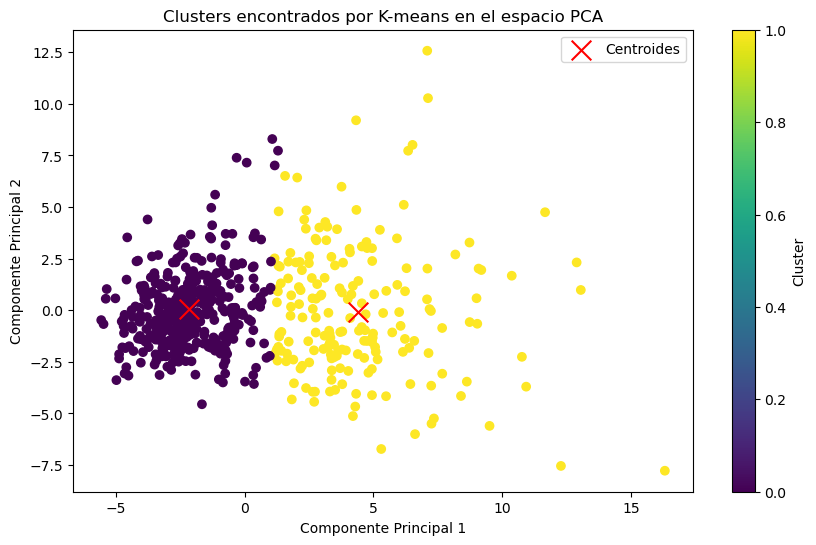

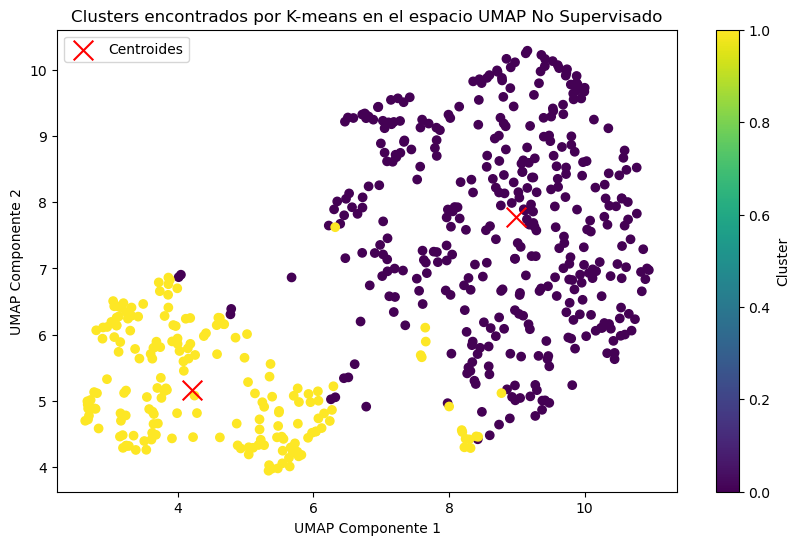

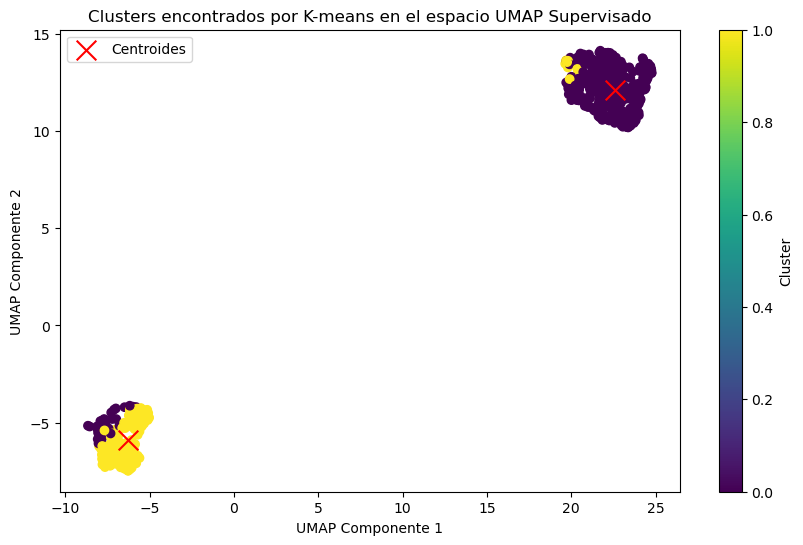

In [16]:
# Visualizar los clusters encontrados por K-means en el espacio PCA
plot_projection(X_pca, clusters, centroids=pca.transform(centroids), title='Clusters encontrados por K-means en el espacio PCA', xlabel='Componente Principal 1', ylabel='Componente Principal 2')

# Visualizar los clusters encontrados por K-means en el espacio UMAP no supervisado
plot_projection(X_umap_unsupervised, clusters, centroids=umap_unsupervised.transform(centroids), title='Clusters encontrados por K-means en el espacio UMAP No Supervisado', xlabel='UMAP Componente 1', ylabel='UMAP Componente 2')

# Visualizar los clusters encontrados por K-means en el espacio UMAP supervisado
plot_projection(X_umap_supervised, clusters, centroids=umap_supervised.transform(centroids), title='Clusters encontrados por K-means en el espacio UMAP Supervisado', xlabel='UMAP Componente 1', ylabel='UMAP Componente 2')


# 10. Construcción de un Clasificador Generativo usando una Mezcla de Gaussianas

Como último punto, construya un clasificador generativo, utilizando una mezcla de gaussianas (GaussianMixture) para representar la distribución de densidad de cada una de las clases \(p(x|y)\). Ese método utiliza el algoritmo de esperanza-maximización para encontrar las distribuciones requeridas.

Con los modelos de cada clase, seleccione como clase ganadora aquella que conduce a la mayor probabilidad a posteriori \(p(y|x)\).

Debe utilizar algún método de selección de modelos (como por ejemplo el descrito aquí) para encontrar cuántas gaussianas aproximan bien la distribución de densidad probabilística de cada clase.

Debe partir sus datos en: datos de entrenamiento, de validación y de prueba, para esta parte, y utilizarlos como corresponde.


In [17]:
# Dividir los datos en conjuntos de entrenamiento, validación y prueba
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("Tamaño del conjunto de entrenamiento:", X_train.shape)
print("Tamaño del conjunto de validación:", X_val.shape)
print("Tamaño del conjunto de prueba:", X_test.shape)

def select_best_gmm(X, n_components_range, cv_folds=5):
    """Selecciona el mejor GMM basado en BIC."""
    lowest_bic = np.infty
    best_gmm = None
    best_n_components = None
    for n_components in n_components_range:
        gmm = GaussianMixture(n_components=n_components, random_state=42)
        gmm.fit(X)
        bic = gmm.bic(X)
        if bic < lowest_bic:
            lowest_bic = bic
            best_gmm = gmm
            best_n_components = n_components
    return best_gmm, best_n_components

# Rangos de componentes a probar
n_components_range = range(1, 11)

# Entrenar GMM para cada clase
gmms = {}
best_n_components_dict = {}
for label in np.unique(y_train):
    X_class = X_train[y_train == label]
    best_gmm, best_n_components = select_best_gmm(X_class, n_components_range)
    gmms[label] = best_gmm
    best_n_components_dict[label] = best_n_components
    print(f"Clase {label}: Mejor número de componentes = {best_n_components}")

# Validar el modelo usando el conjunto de validación
def predict_gmm(gmms, X):
    """Predice la clase basada en los modelos GMM."""
    log_probs = np.array([gmm.score_samples(X) for gmm in gmms.values()]).T
    return np.argmax(log_probs, axis=1)

Tamaño del conjunto de entrenamiento: (341, 30)
Tamaño del conjunto de validación: (114, 30)
Tamaño del conjunto de prueba: (114, 30)
Clase 0.0: Mejor número de componentes = 2
Clase 1.0: Mejor número de componentes = 1


Precisión en el conjunto de prueba: 0.9386


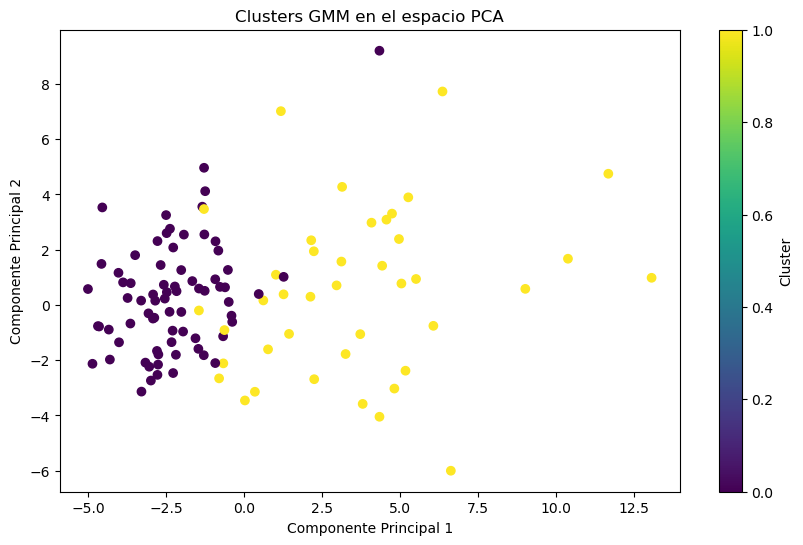

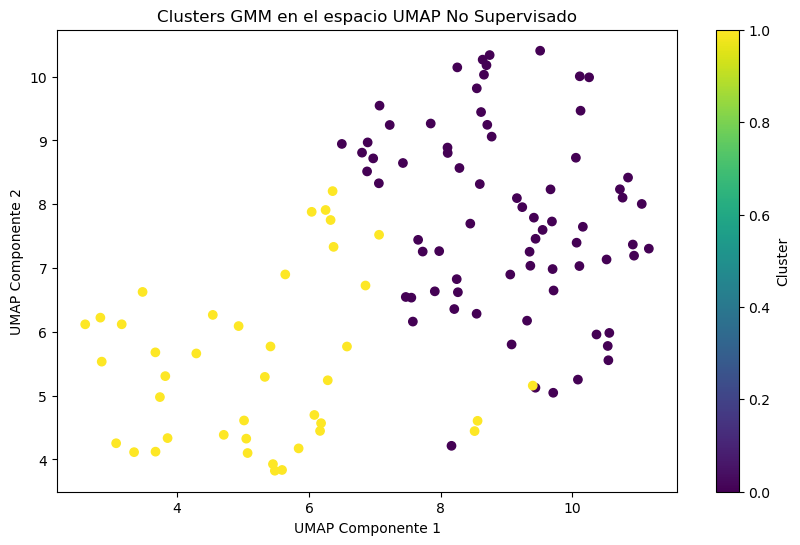

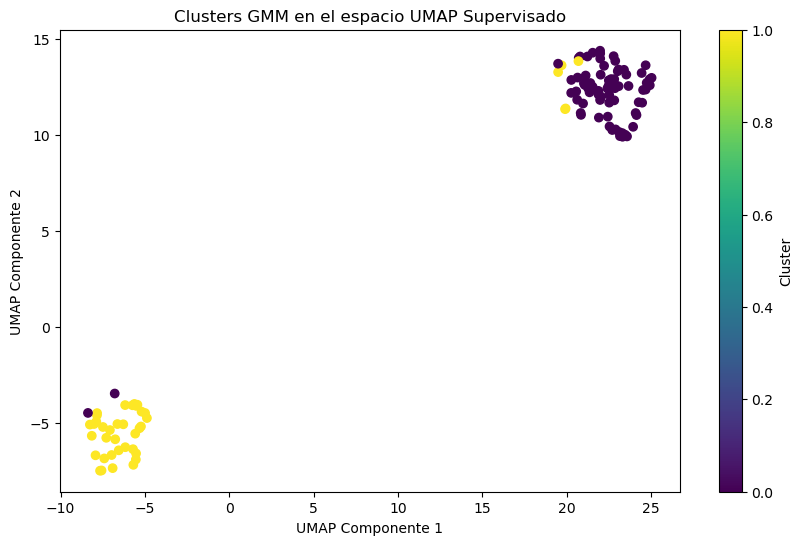

In [18]:
# Predecir y evaluar en el conjunto de prueba
y_test_pred = predict_gmm(gmms, X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Precisión en el conjunto de prueba: {test_accuracy:.4f}")

# Proyecciones en el espacio PCA y UMAP para el conjunto de prueba
X_test_pca = pca.transform(X_test)
X_test_umap_unsupervised = umap_unsupervised.transform(X_test)
X_test_umap_supervised = umap_supervised.transform(X_test)

# Visualizar resultados en el espacio PCA y UMAP para el conjunto de prueba
plot_projection(X_test_pca, y_test_pred, title='Clusters GMM en el espacio PCA', xlabel='Componente Principal 1', ylabel='Componente Principal 2')
plot_projection(X_test_umap_unsupervised, y_test_pred, title='Clusters GMM en el espacio UMAP No Supervisado', xlabel='UMAP Componente 1', ylabel='UMAP Componente 2')
plot_projection(X_test_umap_supervised, y_test_pred, title='Clusters GMM en el espacio UMAP Supervisado', xlabel='UMAP Componente 1', ylabel='UMAP Componente 2')
